# Overview

This exercise demonstrates a method for estimating surface-level NO2 concentrations using a combination of TEMPO satellite and GEOS-CF model data.

**Notebook Author / Affiliation**

* Author: Carl Malings / NASA ARSET
* This notebook is based on examples from the [ASDC Data and User Services Github](https://github.com/nasa/ASDC_Data_and_User_Services).

## Package Installation and Setup

*Instructions*

* Run the cell below to install the non-standard packages required for this exercise. Since we are overwriting some packages, Colab will ask you to restart your session once the installations have completed.

*NOTE: This also includes pyrisg, pydap, and netcdf4 packages, in addition to those used in previous exercises*

In [1]:
! pip install -U harmony-py
! pip install cartopy
! pip install pyrsig
! pip install xarray[io]
! pip install -q 'netCDF4<1.6'
! pip install pydap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.7 MB/s eta 0:00:00
  Created wheel for curlify: filename=curlify-2.2.1-py3-none-any.whl size=2667 sha256=0315023e9b7bd8de5659a5e08dbe1762281ba062274490a9edf2fb84a7e0f393
  Stored in directory: /root/.cache/pip/wheels/e1/6b/61/f8560ac125bd64f2b87b9af2f9ae08f8dbaec154f583a9e301
Successfully built curlify
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.1
    Uninstalling shapely-2.1.1:
      Successfully uninstalled shapely-2.1.1
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 4.5.0
    Uninstalling progressbar2-4.5.0:
      Successfully uninstalled progressbar2-4.5.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.0/767.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


*Instructions*

* Run the code cell below to import the required packages.

In [1]:
# Downloading TEMPO data
import datetime as dt
import getpass
import os
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

# Opening TEMPO data files
import xarray as xr

# Creating graphics
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

# Downloading AirNow data
import pyrsig

# Working with data tables
import numpy as np
import pandas as pd

# Estimate Surface NO2 Concentration from TEMPO and GEOS-CF

The first part of this exercise will be to use TEMPO and GEOS-CF data to estimate surface NO2 concentrations for a region and time period of interest.

## Get TEMPO Level-3 NO2 Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 NO2 data for a region and time period of inerest. You can choose your own region and time period, or use the information below to follow along.

**Region of Interest**: Arizona (latitude 31 to 37, longitude -115 to -108)

**Time of Interest**: June 5 to 7, 2024

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 NO2 data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Authenticate EarthData credentials*

In [3]:
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Username:carl_malings
··········


*Build the request*

In [4]:
# This list will save the bounding box limits for later use:
RoI = [-115, 31, -108, 37]

# Structure the request:
request = Request(
    collection=Collection(id='C2930763263-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2024, 6, 5),
        'stop': dt.datetime(2024, 6, 7)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request.is_valid()

True

*Submit and monitor the request*

In [5]:
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = 755acdaf-507f-4d48-a866-2a541b72500b


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [6]:
download_dir = os.path.expanduser("~/tempo_data_surface_aq_exercise")
os.makedirs(download_dir, exist_ok=True)

results = harmony_client.download_all(job_id, directory=download_dir)
all_results_stored = [f.result() for f in results]

print(f"Number of files: {len(all_results_stored)}")

/root/tempo_data_surface_aq_exercise/105927837_TEMPO_NO2_L3_V03_20240605T012740Z_S014_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927838_TEMPO_NO2_L3_V03_20240605T130939Z_S005_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927839_TEMPO_NO2_L3_V03_20240605T140939Z_S006_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927840_TEMPO_NO2_L3_V03_20240605T150939Z_S007_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927841_TEMPO_NO2_L3_V03_20240605T160939Z_S008_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927844_TEMPO_NO2_L3_V03_20240605T190939Z_S011_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927842_TEMPO_NO2_L3_V03_20240605T170939Z_S009_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927843_TEMPO_NO2_L3_V03_20240605T180939Z_S010_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927845_TEMPO_NO2_L3_V03_20240605T200939Z_S012_subsetted.nc4
/root/tempo_data_surface_aq_exercise/105927847_TEMPO_NO2_L3_V03_20240605T220939Z_S014_subsetted.nc4


*Open the files and combine into a single Dataset*

<details>

*Hint:* This is a new step, which combines data from mulitple files into a single varaible called a Dataset. Look at the dimensions of the dataset; notice how there is a "time" dimension, with the length of that dimension equal to the number of files.

</details>

In [13]:
# Create empty lists for the TEMPO NO2 and QC data:
data_list_no2 = []
data_list_qc = []
# Loop through the result files:
for result_file in sorted(all_results_stored):
    # For each file, add the NO2 or QC data from that file to the appropriate list:
    data_list_no2 += [xr.open_datatree(result_file)['product/vertical_column_troposphere']]
    data_list_qc += [xr.open_datatree(result_file)['product/main_data_quality_flag']]

# Concatenate each list into a Dataset along the time dimenion:
tempo_data_no2 = xr.concat(data_list_no2,dim='time')
tempo_data_qc = xr.concat(data_list_qc,dim='time')

# Merge both Datasets together:
tempo_data = xr.merge([tempo_data_no2,tempo_data_qc])

# Examine the result:
tempo_data

<xarray.Dataset> Size: 34MB
Dimensions:                      (longitude: 350, latitude: 300, time: 27)
Coordinates:
  * longitude                    (longitude) float32 1kB -115.0 ... -108.0
  * latitude                     (latitude) float32 1kB 31.01 31.03 ... 36.99
  * time                         (time) datetime64[ns] 216B 2024-06-05T01:27:...
Data variables:
    vertical_column_troposphere  (time, latitude, longitude) float64 23MB 6.0...
    main_data_quality_flag       (time, latitude, longitude) float32 11MB 1.0...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

*Apply quality control*

<details>

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [17]:
tempo_data = tempo_data.where(tempo_data['main_data_quality_flag'] == 0).squeeze()

## Get GEOS-CF Model NO2 Data

**Define a Function to get GEOS-CF Data**

To estimate the surface-level NO2 from the TEMPO tropospheric column NO2, we are going to use the model surface-to-column ratio method. In order to apply this method, we need to get the tropospheric column and surface NO2 concentrations for the same region from a model. We will be using the [NASA GEOS-CF](https://gmao.gsfc.nasa.gov/weather_prediction/GEOS-CF/) model outputs for this excercise.

We have created a function called `append_GEOSCF_NO2_to_dataset` below which takes as input a data array with latitude, longitude, and time dimensions, and outputs the same data, but with two additional varaibles: the GEOS-CF surface-level NO2, called `geoscf_surface_no2`, and the GEOS-CF tropospheric column NO2, called `geoscf_vertical_column_troposphere_no2`. If you are curious, you can look into the details of what the function is doing.

*Instructions*
* Run the next cell to create the function `append_GEOSCF_NO2_to_dataset`.

In [18]:
def append_GEOSCF_NO2_to_dataset(input_array):
    # This function is designed to append surface-level and tropospheric column NO2 values from the GEOS-CF model to an input dataset.
    # Inputs:
    #  - input_array: a three-dimensional xarray Dataset or DataArray object with the dimensions 'latitude', 'longitude', and 'time'
    # Outputs:
    #  - output_array: a three-dimensional xarray Dataset, the same as the input, augmented with with two additional varaibles from GEOS-CF: the surface-level NO2 (geoscf_surface_no2) and the tropospheric column NO2 (geoscf_vertical_column_troposphere_no2)
    #
    # NOTE:
    # This code accesses GEOS-CF data using the GMAP OpeNDAP service:
    # https://opendap.nccs.nasa.gov/dods/gmao/geos-cf
    #
    # Upcoming changes to GEOS-CF versions, variable names, and file structure may cause this access method to no longer function.
    #
    # Please visit the GEOS-CF Data Access webpage for more information:
    # https://gmao.gsfc.nasa.gov/weather_prediction/GEOS-CF/data_access/

    # Convert the input to a dataset, if it is not already:
    if type(input_array) != xr.Dataset:
      try:
        input_array = xr.Dataset({input_array.name:input_array})
      except:
        print('ERROR: input data type can not be converted to a dataset.')

    # Define the maximum and minimum dimensions of the input data to get the extent of interest:
    min_lat = input_array.latitude.values.min() - 0.25 # get the minimum latitude from the input dataset, subtract 0.25 for a buffer
    max_lat = input_array.latitude.values.max() + 0.25 # get the maximum latitude from the input dataset, add 0.25 for a buffer
    min_lon = input_array.longitude.values.min() - 0.25 # get the minimum longitude from the input dataset, subtract 0.25 for a buffer
    max_lon = input_array.longitude.values.max() + 0.25 # get the maximum longitude from the input dataset, add 0.25 for a buffer
    min_time = input_array.time.values.min() - np.timedelta64(1,'h') # get the minimum time from the input dataset, subtract 1 hour for a buffer
    max_time = input_array.time.values.max() + np.timedelta64(1,'h') # get the maximum time from the input dataset, add 1 hour for a buffer

    # Query the GEOS-CF surface-level composition dataset for NO2 for the area and time above:
    geoscf_opendap_aqc = 'https://opendap.nccs.nasa.gov/dods/gmao/geos-cf/assim/aqc_tavg_1hr_g1440x721_v1' # specify the OpeNDAP location for the data
    geoscf_surface_no2 = xr.open_dataset(geoscf_opendap_aqc).loc[{'time':slice(min_time,max_time),'lat':slice(min_lat,max_lat),'lon':slice(min_lon,max_lon)}]['no2'].mean('lev') # access NO2 data for the time and location
    geoscf_surface_no2_renamed = geoscf_surface_no2.rename({'lat':'latitude','lon':'longitude'}) # rename the data dimensions to match the input file dimensions
    geoscf_surface_no2_rescaled = geoscf_surface_no2_renamed * 1e9 # rescale NO2 units from mol per mol to ppb
    geoscf_surface_no2_at_input = geoscf_surface_no2_rescaled.interp_like(input_array,method='nearest') # interpolate the GEOS-CF grid to the input dataset grid

    # Query the GEOS-CF column composition dataset for tropospheric column NO2 for the area and time above:
    geoscf_opendap_xgc = 'https://opendap.nccs.nasa.gov/dods/gmao/geos-cf/assim/xgc_tavg_1hr_g1440x721_x1' # specify the OpeNDAP location for the data
    geoscf_tropcol_no2 = xr.open_dataset(geoscf_opendap_xgc).loc[{'time':slice(min_time,max_time),'lat':slice(min_lat,max_lat),'lon':slice(min_lon,max_lon)}]['tropcol_no2'] # access column NO2 data for the time and location
    geoscf_tropcol_no2_renamed = geoscf_tropcol_no2.rename({'lat':'latitude','lon':'longitude'}) # rename the data dimensions to match the input file dimensions
    geoscf_tropcol_no2_rescaled = geoscf_tropcol_no2_renamed * 1e15 # rescale units from 1.0e15 molec cm-2 to molec cm-2
    geoscf_tropcol_no2_at_input = geoscf_tropcol_no2_rescaled.interp_like(input_array,method='nearest') # interpolate the GEOS-CF grid to the input dataset grid

    # Add the data into the output:
    output_array = input_array
    output_array['geoscf_surface_no2'] = geoscf_surface_no2_at_input
    output_array['geoscf_vertical_column_troposphere_no2'] = geoscf_tropcol_no2_at_input

    # Return the output:
    return output_array

**Get GEOS-CF data for the region and time of interest**

Using the function you just defined, you can get the necessary GEOS-CF data to compute surface-to-column NO2 ratios.

*Instructions*

* Apply the `append_GEOSCF_NO2_to_dataset` function to your level 3 TEMPO dataset from above to append the GEOS-CF NO2 data.

<details>

*Hint*: to apply this function, use the syntax `output = function_name(input)`

</details>

In [19]:
tempo_data_with_geoscf = append_GEOSCF_NO2_to_dataset(tempo_data)

# View the result:
tempo_data_with_geoscf

/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)
/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)


<xarray.Dataset> Size: 91MB
Dimensions:                                 (time: 27, latitude: 300,
                                             longitude: 350)
Coordinates:
  * longitude                               (longitude) float32 1kB -115.0 .....
  * latitude                                (latitude) float32 1kB 31.01 ... ...
  * time                                    (time) datetime64[ns] 216B 2024-0...
Data variables:
    vertical_column_troposphere             (time, latitude, longitude) float64 23MB ...
    main_data_quality_flag                  (time, latitude, longitude) float32 11MB ...
    geoscf_surface_no2                      (time, latitude, longitude) float32 11MB ...
    geoscf_vertical_column_troposphere_no2  (time, latitude, longitude) float32 11MB ...
    ratio                                   (time, latitude, longitude) float32 11MB ...
    surface_no2_estimate                    (time, latitude, longitude) float64 23MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

## Compute the Surface-to-Column Ratio and Estimate Surface-level NO2



Now, you have all the data you need to calculate the GEOS-CF surface-to-column ratio and multiply this by the tropospheric column NO2 from TEMPO to get an estimate of surface-level NO2.  

*Instructions*

* Calculate the surface-to-column NO2 ratio from the GEOS-CF varaibles `geoscf_surface_no2` and `geoscf_vertical_column_troposphere_no2` in your dataset.

* Multiply this ratio by the TEMPO tropospheric column NO2 to get the estimated surface NO2.

<details>

*Hint*: You can do math with variables in a dataset and define the results as new variables in the same dataset. For example:

```dataset['variable 1 times variable 2'] = dataset['variable 1'] * dataset['variable 2']```

```dataset['variable 1 divided by variable 2'] = dataset['variable 1'] / dataset['variable 2']```

</details>

In [20]:
tempo_data_with_geoscf['ratio'] = tempo_data_with_geoscf['geoscf_surface_no2']/tempo_data_with_geoscf['geoscf_vertical_column_troposphere_no2']
tempo_data_with_geoscf['surface_no2_estimate'] = tempo_data_with_geoscf['ratio'] * tempo_data_with_geoscf['vertical_column_troposphere']

# view the result:
tempo_data_with_geoscf

<xarray.Dataset> Size: 91MB
Dimensions:                                 (time: 27, latitude: 300,
                                             longitude: 350)
Coordinates:
  * longitude                               (longitude) float32 1kB -115.0 .....
  * latitude                                (latitude) float32 1kB 31.01 ... ...
  * time                                    (time) datetime64[ns] 216B 2024-0...
Data variables:
    vertical_column_troposphere             (time, latitude, longitude) float64 23MB ...
    main_data_quality_flag                  (time, latitude, longitude) float32 11MB ...
    geoscf_surface_no2                      (time, latitude, longitude) float32 11MB ...
    geoscf_vertical_column_troposphere_no2  (time, latitude, longitude) float32 11MB ...
    ratio                                   (time, latitude, longitude) float32 11MB ...
    surface_no2_estimate                    (time, latitude, longitude) float64 23MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

## Plot Maps of Surface-level NO2 Estimates

The code below is taken from earlier plotting examples, with slight modifications.

*Instructions*

* Examine the code example below and determine where it is trying to get the surface NO2 estimates from.

* Replace this with the appropriate dataset from your code.

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

<details>

*Hint*: The code example assumes that `tempo_data_with_geoscf['surface_no2_estimate']` is the source of the surface-estiamted NO2 data.

*Hint*: There is a set of code at the bottom you can try to uncomment and modify to plot all timestamps in a loop.

</details>


['2024-06-05T01:27:58.149926912' '2024-06-05T13:09:57.144577024'
 '2024-06-05T14:09:57.139960064' '2024-06-05T15:09:57.154941952'
 '2024-06-05T16:09:57.151315968' '2024-06-05T17:09:57.149251072'
 '2024-06-05T18:09:57.150737920' '2024-06-05T19:09:57.148397824'
 '2024-06-05T20:09:57.148844032' '2024-06-05T21:09:57.155208960'
 '2024-06-05T22:09:57.151514880' '2024-06-05T23:09:57.153888000'
 '2024-06-05T23:50:02.157694976' '2024-06-06T00:30:07.144544000'
 '2024-06-06T01:10:12.149425920' '2024-06-06T13:10:00.152455168'
 '2024-06-06T14:10:00.149424128' '2024-06-06T15:10:00.145687040'
 '2024-06-06T16:10:00.142146048' '2024-06-06T17:10:00.139897088'
 '2024-06-06T18:10:00.141367808' '2024-06-06T19:10:00.139085056'
 '2024-06-06T20:10:00.139767040' '2024-06-06T21:10:00.142153984'
 '2024-06-06T22:10:00.139802880' '2024-06-06T23:10:00.140659200'
 '2024-06-06T23:50:05.145412096']


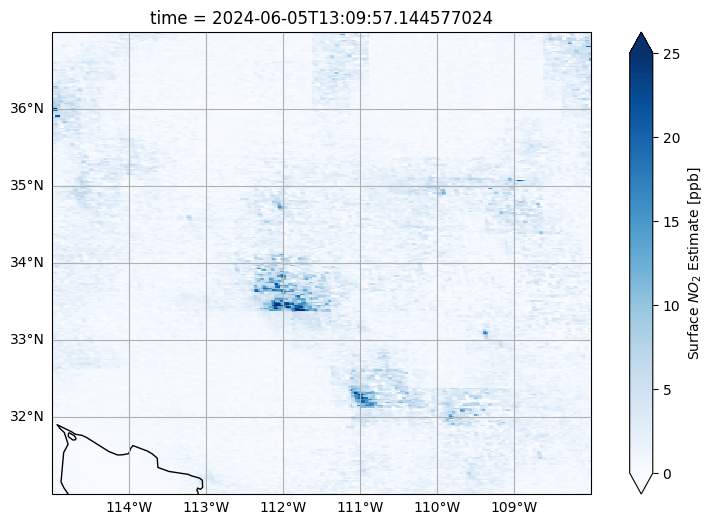

In [47]:
data_proj = ccrs.PlateCarree()

def make_nice_map(axis):
    # axis.add_feature(cfeature.STATES, color="gray", lw=0.1) # This part of the map plotting function has been commented out to make the map show up better
    axis.coastlines(resolution="50m", color="black", linewidth=1.0)

    axis.set_extent([RoI[0], RoI[2], RoI[1], RoI[3]], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

# List the potential timestamps to visualize
print(tempo_data_with_geoscf.time.values)

# Select the data from a timestamp
timestamp = tempo_data_with_geoscf.time.values[1] # e.g., pick the second time in the list
data_to_plot = tempo_data_with_geoscf['surface_no2_estimate'].sel(time=timestamp)

# Plot the data on a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

ax.set_title(timestamp)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('Blues'), # color scale
    vmin=0, # minimum value
    vmax=25, # maximum value
    cbar_kwargs={'label':'Surface $NO_2$ Estimate [ppb]'} # set colorbar label
)

plt.show()

# Uncomment the code below to plot all timestamps:
#fig, axs = plt.subplots(
#    nrows=len(tempo_data_with_geoscf.time.values),
#    sharex=True,
#    figsize=(5, 50),
#    gridspec_kw=dict(hspace=0.5),
#    subplot_kw={"projection": data_proj},
#)

#for i,timestamp in enumerate(tempo_data_with_geoscf.time.values):
#    Var = tempo_data_with_geoscf.sel(time=timestamp)['surface_no2_estimate']
#    make_nice_map(axs[i])
#    Var.plot(ax=axs[i],cmap=plt.get_cmap('Blues'),vmin=0,vmax=25,cbar_kwargs={'label':'$NO_2$ [ppb]'})
#    axs[i].set_title(timestamp, fontsize=8)

#plt.show()

# Compare with AirNow NO2 Monitor Data

We will now compare the TEMPO-derived NO2 estimates with monitored NO2 data from AirNow. This will allow us to begin assessing the quality of the estimate.

## Use pyrsig to download AirNow NO2

We will use the [pyrsig package](https://barronh.github.io/pyrsig/) to easily bring the AirNow NO2 data into python. Below is a template for how a query is structured and submitted to pyrsig. The result will be a data table with the NO2 data, timestamps, and station information.

*Instructions*

* Modify the template to have the approrpiate start end and dates.

* Modify the template to have the appropriate bounding box for the region of interest.

* Run the cell to examine the output table.

In [48]:
# Define the query for pyrisg:
api = pyrsig.RsigApi(bdate="2024-06-05", # start date of the query, in the format "YYYY-MM-DD"
                     edate="2024-06-07", # end date of the query, in the format "YYY-MM-DD"
                     bbox=(RoI[0],RoI[1],RoI[2],RoI[3]), # bounding box for the query, in the format (minimum_longitude,minimum_latitude,maximum_longitude,maximum_latitude)
                     workdir='tmp', # temporary directory to store the downloaded data
                     gridfit=True) # data are not being re-aligned to a grid
airnowkey = "airnow.no2" # this is the pyrsig code to specify NO2 data from AirNow

# Execute the query to download the data:
airnow_data = api.to_dataframe(airnowkey, unit_keys=False, parse_dates=True)

# Examine the resulting table:
airnow_data

,Timestamp,LONGITUDE,LATITUDE,STATION,no2,SITE_NAME,time
0,2024-06-05T00:00:00-0000,-112.14260,33.48380,7231,4.0,840040130019;42602,2024-06-05 00:00:00+00:00
1,2024-06-05T00:00:00-0000,-112.04600,33.45790,7239,5.0,840040133002;42602,2024-06-05 00:00:00+00:00
2,2024-06-05T00:00:00-0000,-112.62070,33.37000,7249,0.0,840040134011;42602,2024-06-05 00:00:00+00:00
3,2024-06-05T00:00:00-0000,-112.12804,33.46181,7253,15.0,840040134020;42602,2024-06-05 00:00:00+00:00
4,2024-06-05T00:00:00-0000,-112.00264,33.41046,7254,8.0,840040134021;42602,2024-06-05 00:00:00+00:00
...,...,...,...,...,...,...,...
329,2024-06-07T00:00:00-0000,-112.62070,33.37000,7249,3.0,840040134011;42602,2024-06-07 00:00:00+00:00
330,2024-06-07T00:00:00-0000,-112.12804,33.46181,7253,14.0,840040134020;42602,2024-06-07 00:00:00+00:00
331,2024-06-07T00:00:00-0000,-112.00264,33.41046,7254,7.0,840040134021;42602,2024-06-07 00:00:00+00:00
332,2024-06-07T00:00:00-0000,-112.09500,33.50360,7266,3.8,840040139997;42602,2024-06-07 00:00:00+00:00


## Extract TEMPO-estimated NO2 values at monitor locations and sampling times

For comparing the data, will will add our TEMPO-estimated NO2 values into this table. A code loop is set up to do this below, but it assumes the estimated surface NO2 concentrations from TEMPO are in a specifically named dataset which might not exist in your run of the code.

*Instructions*

* Examine the code example below and determine where it is trying to get the surface NO2 estimates from.

* Replace this with the appropriate dataset from your code.

* Run the cell and check the output.

<details>

*Hint*: The code example assumes that `tempo_data_with_geoscf['surface_no2_estimate']` is the source of the surface-estiamted NO2 data.

*Hint*: This code also converts the timestamps into local time, using an assumed time zone (MST). Be sure to change this time zone if you are looking in a different area.


In [49]:
# Create a new column in the table to store the TEMPO-estimated NO2; initialize it to NaN values using np.nan
airnow_data['no2_TEMPO_ESTIMATE'] = np.nan

# For convenience, we will also add a column time column:
airnow_data['local_time'] = np.nan

# Loop through the rows of the table:
for row in range(len(airnow_data)):
  site_latitude = airnow_data['LATITUDE'][row] # latitude of the monitor
  site_longitude = airnow_data['LONGITUDE'][row] # longitude of the monitor
  sample_start_time = np.datetime64(airnow_data['Timestamp'][row][0:19]) # timestamp of the row, converted to a numpy datetime object for compatibility with xarray
  sample_end_time = sample_start_time + np.timedelta64(1,'h') # increment the timestamp by one hour, to account for the end of the one-hour sample

  # This line interpolates the array of estimated surface NO2 to the latitude and longitude of the monitor, selects times within the sampling time interval, and returns the average:
  no2_estimate = tempo_data_with_geoscf['surface_no2_estimate'].interp(latitude=site_latitude,longitude=site_longitude).sel(time=slice(sample_start_time,sample_end_time)).mean('time').values

  # Store this estimated NO2 value into the appropriate row and column of the table:
  airnow_data.loc[row,'no2_TEMPO_ESTIMATE'] = no2_estimate

  # Convert the timestamp to local time for convenience and store the value in the appropriate row and column of the table:
  # Note that the tz input to the tz_convert function is the local time zone.
  airnow_data.loc[row,'local_time'] = airnow_data['time'][row].tz_convert(tz='MST')

# Examine the resulting table:
airnow_data

/tmp/ipython-input-49-3226497737.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-06-04 17:00:00-07:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  airnow_data.loc[row,'local_time'] = airnow_data['time'][row].tz_convert(tz='MST')


,Timestamp,LONGITUDE,LATITUDE,STATION,no2,SITE_NAME,time,no2_TEMPO_ESTIMATE,local_time
0,2024-06-05T00:00:00-0000,-112.14260,33.48380,7231,4.0,840040130019;42602,2024-06-05 00:00:00+00:00,NaN,2024-06-04 17:00:00-07:00
1,2024-06-05T00:00:00-0000,-112.04600,33.45790,7239,5.0,840040133002;42602,2024-06-05 00:00:00+00:00,NaN,2024-06-04 17:00:00-07:00
2,2024-06-05T00:00:00-0000,-112.62070,33.37000,7249,0.0,840040134011;42602,2024-06-05 00:00:00+00:00,NaN,2024-06-04 17:00:00-07:00
3,2024-06-05T00:00:00-0000,-112.12804,33.46181,7253,15.0,840040134020;42602,2024-06-05 00:00:00+00:00,NaN,2024-06-04 17:00:00-07:00
4,2024-06-05T00:00:00-0000,-112.00264,33.41046,7254,8.0,840040134021;42602,2024-06-05 00:00:00+00:00,NaN,2024-06-04 17:00:00-07:00
...,...,...,...,...,...,...,...,...,...
329,2024-06-07T00:00:00-0000,-112.62070,33.37000,7249,3.0,840040134011;42602,2024-06-07 00:00:00+00:00,NaN,2024-06-06 17:00:00-07:00
330,2024-06-07T00:00:00-0000,-112.12804,33.46181,7253,14.0,840040134020;42602,2024-06-07 00:00:00+00:00,NaN,2024-06-06 17:00:00-07:00
331,2024-06-07T00:00:00-0000,-112.00264,33.41046,7254,7.0,840040134021;42602,2024-06-07 00:00:00+00:00,NaN,2024-06-06 17:00:00-07:00
332,2024-06-07T00:00:00-0000,-112.09500,33.50360,7266,3.8,840040139997;42602,2024-06-07 00:00:00+00:00,NaN,2024-06-06 17:00:00-07:00


## Time Series Comparison Plot

We will now compare the TEMPO-estimated NO2 with the measured NO2 at a surface monitor station. Use the code template below to generate a time-series plot comparing these values for a single site.

*Instructions*

* Run the cell to generate the plot.

* Try changing the site name to look at different sites.

* Note which sites the estimates seem to be doing well at, and which sites they are doing poorly.



['                          840040130019;42602'
 '                          840040133002;42602'
 '                          840040134011;42602'
 '                          840040134020;42602'
 '                          840040134021;42602'
 '                          840040139997;42602'
 '                          840350451005;42602']


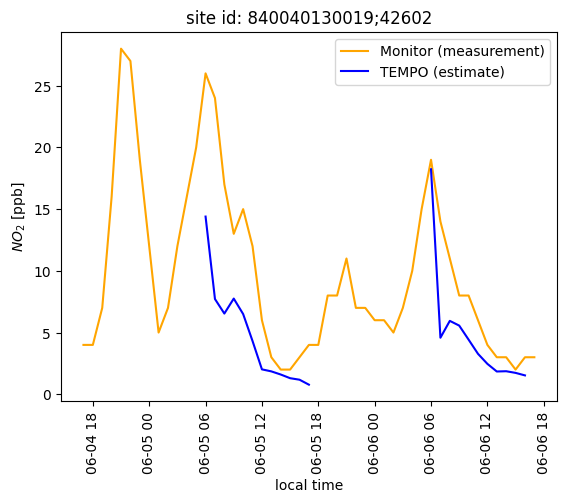

In [50]:
# list available sites:
print(np.unique(airnow_data['SITE_NAME']))

# choose a site:
site = '                          840040130019;42602'
airnow_data_site = airnow_data.where(airnow_data['SITE_NAME'] == site).dropna(how='all')

# Create a plot:
figure, axis = plt.subplots()
axis.plot(airnow_data_site['local_time'],airnow_data_site['no2'],color='orange',label='Monitor (measurement)')
axis.plot(airnow_data_site['local_time'],airnow_data_site['no2_TEMPO_ESTIMATE'],color='blue',label='TEMPO (estimate)')
plt.legend()
plt.xlabel('local time')
plt.ylabel('$NO_2$ [ppb]')
plt.xticks(rotation=90)
plt.title('site id: {}'.format(site.replace(' ','')))
plt.show()



## Map Comparison Plot

Finally, we will create a map of the TEMPO-derived NO2 estimates and overlay the surface NO2 monitor data as points. The code example below should generate this plot, but again, it assumes the estimated surface NO2 concentrations from TEMPO are in a specifically named dataset which might not exist in your run of the code.

*Instructions*

* Examine the code below to see where it is getting its TEMPO-derived NO2 estimates from, and replace this with the correct dataset from your run of the code.

* Once you have gotten the example to run successfully, try changing the hour of interest and re-running. See if the spatial patterns of NO2 estimated by TEMPO seem to agree with the pattern of surface monitor data.

<details>

*Hint*: Try copying subsets of the code into a new cell to run it incrementally, and see where the errors are coming from. Put the name of a variable in a cell by itself and run that cell to see what the variable looks like.

/tmp/ipython-input-52-846726177.py:5: UserWarning: no explicit representation of timezones available for np.datetime64
  plot_hour_start_utc = np.datetime64(hour_of_interest.tz_convert(tz='UTC'))


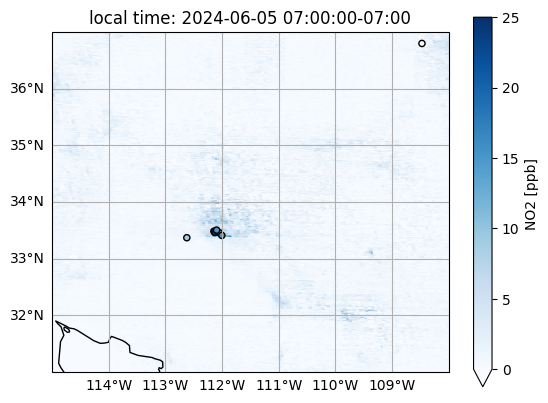

In [52]:
# Define an hour of interest for plotting:
hour_of_interest = pd.Timestamp('2024-06-05 07:00:00',tz='MST')

# Get the start and end timestamps, in UTC and in numpy format for xarray compatibility:
plot_hour_start_utc = np.datetime64(hour_of_interest.tz_convert(tz='UTC'))
plot_hour_end_utc = plot_hour_start_utc + np.timedelta64(1,'h')

# Select the surface NO2 estimate data corresponding to the time of interest:
tempo_no2_estimate_to_plot = tempo_data_with_geoscf['surface_no2_estimate'].sel(time=slice(plot_hour_start_utc,plot_hour_end_utc)).mean('time')

# Select the AirNow NO2 data to plot:
airnow_no2_to_plot = airnow_data.where(airnow_data['local_time'] == hour_of_interest).dropna(how='all')

# Make the plot:
figure, axis = plt.subplots(
    subplot_kw={"projection": data_proj},
)
make_nice_map(axis)
tempo_no2_estimate_to_plot.plot(ax=axis,cmap=plt.get_cmap('Blues'),vmin=0,vmax=25,cbar_kwargs={'label':'NO2 [ppb]'})
axis.scatter(airnow_no2_to_plot['LONGITUDE'],airnow_no2_to_plot['LATITUDE'],s=20,c=airnow_no2_to_plot['no2'],cmap=plt.get_cmap('Blues'),vmin=0,vmax=25,edgecolors='black')
axis.set_title('local time: {}'.format(hour_of_interest))
plt.show()

# Bonus: Create Time-of-Day Average Map Plots

It may be useful to aggregate TEMPO data across multiple days to achieve a more robust estimate. However, to retain the benefit of TEMPO's hourly observations, this aggregation might be done for specific times of day. Below is a code example showing how this can be done. Note that we are only aggregating data for a couple of days in this example; aggregating across weeks or months can yield a more robust estimate.

*Instructions*

* Modify the code example below to use the correct dataset where you stored your TEMPO-estimated surface NO2.

* Run the cell to generate a plot of surface estimated NO2, averaged across the time period of interest but at a specific time of day. Averaged NO2 from AirNow monitors at the same time of day are overlaid on this map.

* Change the time of day of interest to examine other times of day.

<details>

*Hint*: The code example assumes the the surface-estimated NO2 from TEMPO are contained in the `tempo_data_with_geoscf` dataset.



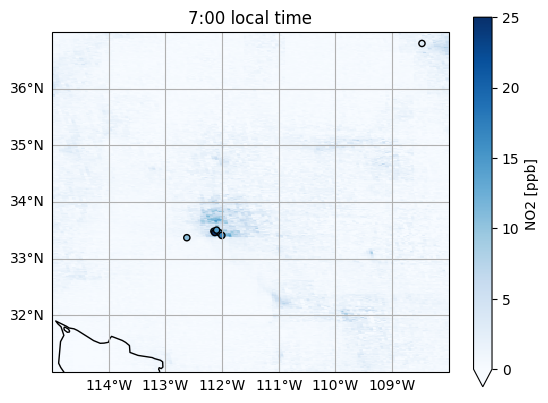

In [53]:
# Add a local-time-of-day coordinate for the local time of day for the TEMPO dataset:
local_times = [pd.Timestamp(timestamp,tz='UTC').tz_convert(tz='MST') for timestamp in tempo_data_with_geoscf.time.values]
local_times_of_day = [local_time.hour for local_time in local_times]

tempo_data_with_geoscf = tempo_data_with_geoscf.assign_coords({'local_time_of_day':('time',local_times_of_day)})

tempo_data_with_geoscf_time_of_day_average = tempo_data_with_geoscf.groupby('local_time_of_day').mean('time')

# Repeat the process for the AirNow data table:
airnow_data['local_time_of_day'] = [timestamp.hour for timestamp in airnow_data['local_time']]

airnow_data_time_of_day_average = airnow_data.groupby(['SITE_NAME','local_time_of_day']).mean('time').reset_index()

# Plot the results for a specific time of day:
time_of_day_to_plot = 7

tempo_no2_estimate_to_plot = tempo_data_with_geoscf_time_of_day_average.sel({'local_time_of_day':time_of_day_to_plot})['surface_no2_estimate']
airnow_no2_to_plot = airnow_data_time_of_day_average.where(airnow_data_time_of_day_average['local_time_of_day']==time_of_day_to_plot).dropna(how='all')

figure, axis = plt.subplots(
    subplot_kw={"projection": data_proj},
)
make_nice_map(axis)
tempo_no2_estimate_to_plot.plot(ax=axis,cmap=plt.get_cmap('Blues'),vmin=0,vmax=25,cbar_kwargs={'label':'NO2 [ppb]'})
axis.scatter(airnow_no2_to_plot['LONGITUDE'],airnow_no2_to_plot['LATITUDE'],s=20,c=airnow_no2_to_plot['no2'],cmap=plt.get_cmap('Blues'),vmin=0,vmax=25,edgecolors='black')
axis.set_title('{}:00 local time'.format(time_of_day_to_plot))
plt.show()